# Deep Learning with Lightning

This lab is design for investigating the basic architecture and parameter searching techniques in deep learning literature. We use a fundamental dataset, MNIST, with the help of PyTorch Lightning and design our model to handle image classification task.

#### Instructions

* You can achieve up to **20 points** for this graded notebook. The points for each task are clearly declared in the task descriptions. Fill in the missing code fragments and answer questions whenever you see this symbol: &#x1F536;. Please do not change any of the provided code. Notice that one symbol &#x1F536; does NOT mean one-line code: sometimes it can require several code of lines.

* Team work is not allowed! Everybody implements his/her own code. Discussing issues with others is fine, sharing code with others is not. 

* If you use any code fragments found on the internet, make sure you reference them properly.

* The responsible TA for this lab are **Yuchang** and **Sara**, if you have further questions please reach out to them directly: **yuchang.jiang@uzh.ch** and **sara.zoccheddu@uzh.ch**.

* Since the lab sessions are specifically designed to answer your questions please make sure to attend those and only reach out if further questions pop up later.

* Hand in your solution via OLAT until <span style="color:#4ea373">**15.05.2025**</span>. Make sure that all cells are execute as we will not rerun any code. Any cell that is not executed will automatically result in 0 points for this task. 
</div>

#### Suggestions

Please install pytorch lightning packages via conda or pip before starting the lab session. You can use the tutorials of [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html).

Please also check: [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)

For installing lightning: [Link](https://lightning.ai/pytorch-lightning)

Please keep in mind that this is a valuable opportunity to develop self-learning skills. When working with a new package like PyTorch Lightning, always refer to the official documentation or search for solutions online when encountering errors, rather than immediately asking a friend or TA. This habit will greatly enhance your ability to troubleshoot and learn independently.

#### Task Overview

------------------------------------------------------------------------------------------

1. **Datasets** <span style="color:#4ea373">**[3pt]**</span>
2. **NN Architectures** <span style="color:#4ea373">**[5pt]**</span>
2. **Experiments** <span style="color:#4ea373">**[5pt]**</span>
2. **Results** <span style="color:#4ea373">**[4pt]**</span>
2. **Conclusions** <span style="color:#4ea373">**[3pt]**</span>

In [3]:
# Basic Machine Learning Modules
import pandas
import numpy
import sklearn

# Deep Learning Modules
import torch
import lightning.pytorch as pl

# Visualization Modules
import matplotlib.pyplot as plt

# Others
from torchvision.datasets import MNIST
from torchvision import transforms
from torchmetrics import Accuracy
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import TQDMProgressBar
import warnings
warnings.filterwarnings("ignore")  # You can comment out this line while debuging, not in submission!

numpy.random.seed(42)
torch.set_float32_matmul_precision('medium')
torch.manual_seed(42)
pl.seed_everything(42, workers=True)

DATASET_PATH = '/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST'  # You can change them
EXPERIMENTS_PATH = '/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp'  # You can change them

Seed set to 42


# 1) Dataset (3 Points)

- Design a DataModule for MNIST.
- Use 80/20 % split for train/val sets.

In [4]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_folder: str = DATASET_PATH, batch_size: int = 64, num_cpu: int = 1):
        super().__init__()
        self.path = data_folder
        self.batch_size = batch_size
        self.num_cpu = num_cpu
        self.transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    def prepare_data(self) -> None:
        # 🔶 TODO: Download MNIST Data in self.path
        MNIST(root = self.path, train=True, download=True)
        MNIST(root = self.path, train=False, download=True)

    
    def setup(self, stage: str = 'fit') -> None:
        # 🔶 TODO: Insert your code 
        # HINT: how to split the whole dataset into train, val sets? 
        # and how should those sets be used in different stages?
        
        if stage in ['fit', 'tune']:
            full_train = MNIST(root=self.path, train=True, transform=self.transform)
            train_size = int(0.8 * len(full_train))
            val_size = len(full_train) - train_size
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(full_train, [train_size, val_size])
        
        if stage in ['fit', 'tune', 'validate']:
            if not hasattr(self, 'val_dataset'):
                full_train = MNIST(root=self.path, train=True, transform=self.transform)
                train_size = int(0.8 * len(full_train))
                val_size = len(full_train) - train_size
                _, self.val_dataset = torch.utils.data.random_split(full_train, [train_size, val_size])
        
        elif stage in ['test', 'predict']:
            self.test_dataset = MNIST(root = self.path, train = False, transform = self.transform)  # 🔶 TODO: Insert your code 
        
        else:
            raise NotImplementedError('Unknown Stage: {}'.format(stage))
            
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(
            batch_size=self.batch_size, num_workers=self.num_cpu,  # DO NOT CHANGE IN VAL/TEST LOADERS
            dataset=self.train_dataset, shuffle=True,  # Could be changed in val/test loaders
        )
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        # 🔶 TODO: Insert your code
        # HINT: check docs of 'torch.utils.data.DataLoader'.
        return torch.utils.data.DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_cpu,
            shuffle = False,
        )
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        # 🔶 TODO: Insert your code
        # HINT: what's the difference between 'val_dataloader' and 'test_dataloader'?
        return torch.utils.data.DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_cpu,
            shuffle = False,
        )
        
    def predict_dataloader(self) -> torch.utils.data.DataLoader:
        return self.test_dataloader()

data_module = MNISTDataModule()
data_module.prepare_data()
data_module.setup('fit')
dl = data_module.train_dataloader()
print(next(dl.__iter__()))  # DO NOT CHANGE | will be used for checking

[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.42

In [5]:
# Do not change! Only for checking.
print('Shape of Images: [B x C x H x W] = ', next(dl.__iter__())[0].shape)
print('Shape of Labels: [B] = ', next(dl.__iter__())[1].shape)

Shape of Images: [B x C x H x W] =  torch.Size([64, 1, 28, 28])
Shape of Labels: [B] =  torch.Size([64])


## 2) Neural Network Architecture (5 Points)

- Design an model with 3 Convolutional layers and 1 fully-connected layer, in this order:
    - Convolution: Kernel size = 3x3, padding = 'same', number of filters = 4
    - Convolution: Kernel size = 3x3, padding = 'same', number of filters = 8
    - Convolution: Kernel size = 3x3, padding = 'same', number of filters = 4
    - Linear: No Bias, num_class = 10 in MNIST Dataset
- Use rectified linear unit (ReLU) for activation function (when necessary). 
- Initialize all the weights with `xavier_uniform`.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RawModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 🔶 TODO: Insert your code
        # HINT: define model layers based on the given model design (Conv2d...)
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features = 4 * 28 * 28, out_features = 10),
        )
        
        self.model.apply(self.initialize_weights)
    
    @staticmethod
    def initialize_weights(module: torch.nn.Module) -> None:
        # 🔶 TODO: Insert your code
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
        
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Input: torch.Tensor | dtype=torch.float | shape=[B, C, H, W]
        Output: torch.Tensor | dtype=torch.float | shape=[B, num_class]
        """
        # 🔶 TODO: Insert your code
        return self.model(images)

model = RawModel()
with torch.no_grad():  # DO NOT REMOVE THIS LINES BELOW
    sample_image = torch.rand(size=(4, 1, 28, 28))
    output = model(sample_image)
    print(output.shape, output.dtype)  
    print(output)


torch.Size([4, 10]) torch.float32
tensor([[-1.3407,  0.6474,  1.3574,  0.7361,  1.8476, -0.3699, -0.1215, -0.0558,
         -0.7714, -0.3651],
        [-1.1083,  0.7181,  1.3379,  0.8089,  2.0845, -0.8070,  0.0117,  0.3289,
         -0.7864, -0.8928],
        [-1.5244,  0.4468,  1.2048,  0.9522,  1.9017, -0.7932,  0.0053,  0.1596,
         -0.7596, -0.6852],
        [-1.5235,  0.5117,  0.9190,  0.7907,  2.2066, -0.6643, -0.2235,  0.2211,
         -0.5628, -0.6289]])


## 3) Experiments (5 Points)

- Define training/validation/test step and optimizer with cross-entropy loss and `AdamW` optimizer.
- Use accuracy scores for monitoring the experiment. (you can use multiclass accuracy from Lightning Metrics)

In [7]:
import torch
import torch.nn as nn
from torchmetrics import Accuracy
import lightning.pytorch as pl

class MNISTExperiment(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.model = RawModel()
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.train_scores = Accuracy(task = "multiclass", num_classes = 10)   # 🔶 TODO: Insert your code
        # HINT: define the metric used in this classification task.
        self.validation_scores = Accuracy(task = "multiclass", num_classes = 10)  # 🔶 TODO: Insert your code
        self.test_scores = Accuracy(task = "multiclass", num_classes = 10)  # 🔶 TODO: Insert your code

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch
        y_hat = self(x)
        
        # 🔶 TODO: Insert your code: Loss Calculation
        loss = self.criterion(y_hat, y)
        # 🔶 TODO: Insert your code: Score Calculation
        acc = self.train_scores(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx) -> None:
        # 🔶 TODO: Insert your code
        x, y = batch
        y_hat = self(x)
        acc = self.validation_scores(y_hat, y)
        self.log('validation_accuracy', acc)
    
    def test_step(self, batch, batch_idx) -> None:
        # 🔶 TODO: Insert your code
        x, y = batch
        y_hat = self(x)
        acc = self.test_scores(y_hat, y)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)  # 🔶 TODO: Insert your code 
        return optimizer

experiment = MNISTExperiment()

- Define a lightning `Trainer`:
    - Maximum epoch = 20
    - accelerator = 'auto'
    - Use `CSVLogger` and `TensorBoardLogger`
    - Use `EarlyStopping` with patience epoch = 3
    - Use `TQDMProgressBar` with refresh rate = 10

In [8]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    logger=[
        CSVLogger(EXPERIMENTS_PATH, name='MNIST_Experiment'),
        TensorBoardLogger(EXPERIMENTS_PATH, name='MNIST_Experiment')
    ],
    callbacks=[TQDMProgressBar(refresh_rate=10)]
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 4) Results (4 Points)
- Train and test the `RawModel` and plot the score and loss values versus epoch.

In [9]:
data_module = MNISTDataModule(DATASET_PATH)
experiment = MNISTExperiment()

data_module.prepare_data()
data_module.setup("fit")
trainer.fit(experiment, datamodule=data_module)
trainer.test(experiment, datamodule=data_module)

2025-05-13 18:44:16.266616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | model             | RawModel           | 32.0 K | train
1 | criterion         | CrossEntropyLoss   | 0      | train
2 | train_scores      | MulticlassAccuracy | 0      | train
3 | validation_scores | MulticlassAccuracy | 0      | train
4 | test_scores       | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9796000123023987     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9796000123023987}]

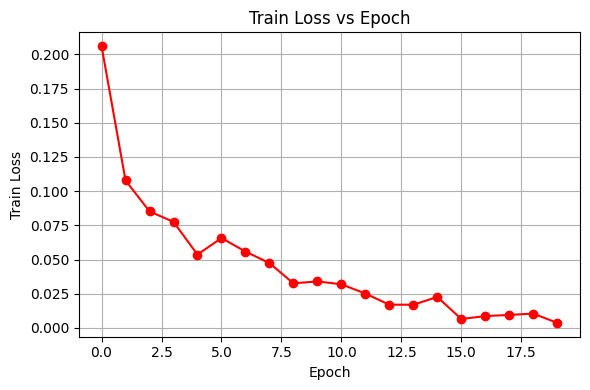

In [12]:
import pandas as pd

metrics_path = "/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp/MNIST_Experiment/version_0/metrics.csv"

df = pd.read_csv(metrics_path)

df = df.dropna(subset=["train_loss"])

loss_per_epoch = df.groupby("epoch")["train_loss"].mean()

plt.figure(figsize=(6, 4))
plt.plot(loss_per_epoch.index, loss_per_epoch.values, marker='o', color='red')
plt.title("Train Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


- Re-design the model with `Dropout` layer in-between the convolutional layers and re-train the model. as like `RawModel` and create a new module as `ModelWithDropout`. Try:
    - dropout probability = 0.1
    - dropout probability = 0.5
    - dropout probability = 0.9

In [13]:
# 🔶 Insert your code
# HINT: 
# re-create a new model class like 'class RawModel(torch.nn.Module)'. 
# add Dropout layers.
# then run trainer.fit(...) and trainer.test(...) with this new model architecture.
class DropoutModel(torch.nn.Module):
    def __init__(self, dp=0.5):
        super().__init__()
        self.dp = dp
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Dropout(p=self.dp),
            nn.Flatten(),
            nn.Linear(in_features = 4 * 28 * 28, out_features = 10),
        )
        self.model.apply(self.initialize_weights)
        
    @staticmethod
    def initialize_weights(module: torch.nn.Module) -> None:
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Input: torch.Tensor | dtype=torch.float | shape=[B, C, H, W]
        Output: torch.Tensor | dtype=torch.float | shape=[B, num_class]
        """
        return self.model(images)

model = DropoutModel()
with torch.no_grad():  # DO NOT REMOVE THIS LINES BELOW
    sample_image = torch.rand(size=(4, 1, 28, 28))
    output = model(sample_image)
    print(output.shape, output.dtype)  
    print(output)

class MNISTExperimentDP(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3, dp = 0.5):
        super().__init__()
        self.dp = dp
        self.model = DropoutModel(self.dp)
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        self.train_scores = Accuracy(task = "multiclass", num_classes = 10)   # 🔶 TODO: Insert your code
        # HINT: define the metric used in this classification task.
        self.validation_scores = Accuracy(task = "multiclass", num_classes = 10)  # 🔶 TODO: Insert your code
        self.test_scores = Accuracy(task = "multiclass", num_classes = 10)  # 🔶 TODO: Insert your code

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch
        y_hat = self(x)
        
        # 🔶 TODO: Insert your code: Loss Calculation
        loss = self.criterion(y_hat, y)
        # 🔶 TODO: Insert your code: Score Calculation
        acc = self.train_scores(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx) -> None:
        # 🔶 TODO: Insert your code
        x, y = batch
        y_hat = self(x)
        acc = self.validation_scores(y_hat, y)
        self.log('validation_accuracy', acc)
    
    def test_step(self, batch, batch_idx) -> None:
        # 🔶 TODO: Insert your code
        x, y = batch
        y_hat = self(x)
        acc = self.test_scores(y_hat, y)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)  # 🔶 TODO: Insert your code 
        return optimizer

for val in [0.1, 0.5, 0.9]:
    print(f"Dropout Probability: {val}")
    model = DropoutModel(val)
    experiment = MNISTExperimentDP()
    
    trainer_dp = pl.Trainer(
        max_epochs=20,
        accelerator='auto',
        logger=[
            CSVLogger(EXPERIMENTS_PATH, name='MNIST_Experiment'),
            TensorBoardLogger(EXPERIMENTS_PATH, name='MNIST_Experiment')
        ],
        callbacks=[TQDMProgressBar(refresh_rate=10)]
    )
    
    experiment.model = model
    trainer_dp.fit(experiment, datamodule=data_module)
    trainer_dp.test(experiment, datamodule=data_module)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | model             | DropoutModel       | 32.0 K | train
1 | criterion         | CrossEntropyLoss   | 0      | train
2 | train_scores      | MulticlassAccuracy | 0      | train
3 | validation_scores | MulticlassAccuracy | 0      | train
4 | test_scores       | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


torch.Size([4, 10]) torch.float32
tensor([[-0.0221, -0.0485,  0.0219,  0.0022, -0.0137,  0.0883,  0.0074,  0.2441,
         -0.1822, -0.0408],
        [-0.0541, -0.0359,  0.0562, -0.0094, -0.1926,  0.1289,  0.0519, -0.0148,
         -0.0260, -0.0033],
        [-0.0727, -0.0472,  0.0379,  0.0188, -0.0636,  0.0600, -0.1129,  0.0514,
         -0.0946, -0.0291],
        [ 0.0304, -0.1269, -0.0980, -0.0229, -0.0597,  0.1392, -0.0423,  0.1226,
          0.0888,  0.0476]])
Dropout Probability: 0.1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9825000166893005     │
└───────────────────────────┴───────────────────────────┘

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | model             | DropoutModel       | 32.0 K | train
1 | criterion         | CrossEntropyLoss   | 0      | train
2 | train_scores      | MulticlassAccuracy | 0      | train
3 | validation_scores | MulticlassAccuracy | 0      | train
4 | test_scores       | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Dropout Probability: 0.5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9868999719619751     │
└───────────────────────────┴───────────────────────────┘

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | model             | DropoutModel       | 32.0 K | train
1 | criterion         | CrossEntropyLoss   | 0      | train
2 | train_scores      | MulticlassAccuracy | 0      | train
3 | validation_scores | MulticlassAccuracy | 0      | train
4 | test_scores       | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Dropout Probability: 0.9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9829999804496765     │
└───────────────────────────┴───────────────────────────┘

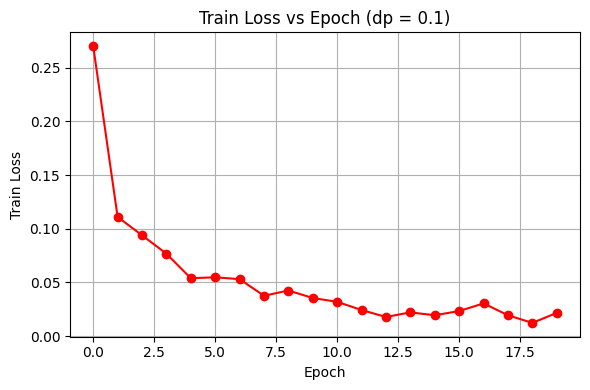

In [14]:
df = pd.read_csv("/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp/MNIST_Experiment/version_2/metrics.csv")

df = df.dropna(subset=["train_loss"])

loss_per_epoch = df.groupby("epoch")["train_loss"].mean()

plt.figure(figsize=(6, 4))
plt.plot(loss_per_epoch.index, loss_per_epoch.values, marker='o', color='red')
plt.title("Train Loss vs Epoch (dp = 0.1)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


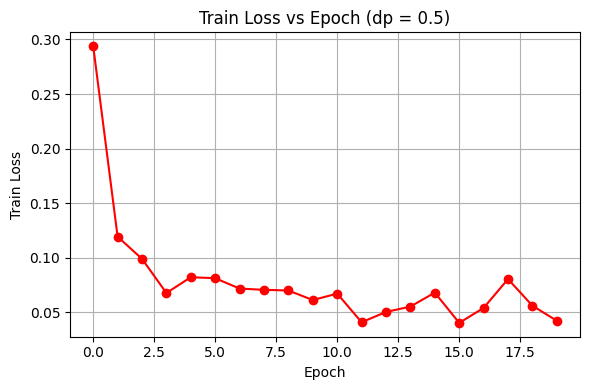

In [15]:
df = pd.read_csv("/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp/MNIST_Experiment/version_4/metrics.csv")

df = df.dropna(subset=["train_loss"])

loss_per_epoch = df.groupby("epoch")["train_loss"].mean()

plt.figure(figsize=(6, 4))
plt.plot(loss_per_epoch.index, loss_per_epoch.values, marker='o', color='red')
plt.title("Train Loss vs Epoch (dp = 0.5)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

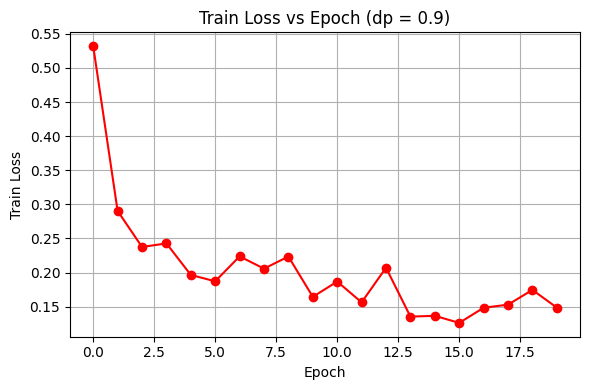

In [16]:
df = pd.read_csv("/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp/MNIST_Experiment/version_6/metrics.csv")

df = df.dropna(subset=["train_loss"])

loss_per_epoch = df.groupby("epoch")["train_loss"].mean()

plt.figure(figsize=(6, 4))
plt.plot(loss_per_epoch.index, loss_per_epoch.values, marker='o', color='red')
plt.title("Train Loss vs Epoch (dp = 0.9)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

- Re-design the model with `BatchNorm` layer in-between the convolutional layers and re-train the model.

In [22]:
# Always got broken pipe error when running differently

class BatchNormModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Added pooling to reduce dimensions
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Added pooling
            
            nn.Flatten(),
            nn.Linear(in_features=8 * 7 * 7, out_features=64),  # Adjusted for pooling
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
        )
        self.model.apply(self.initialize_weights)
        
    @staticmethod
    def initialize_weights(module: torch.nn.Module) -> None:
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, images: torch.Tensor) -> torch.Tensor:
        return self.model(images)

# Test the model
model = BatchNormModel()
with torch.no_grad():
    sample_image = torch.rand(size=(4, 1, 28, 28))
    output = model(sample_image)
    print(output.shape, output.dtype)
    print(output)

class MNISTExperimentBN(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = BatchNormModel()
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.val_acc = Accuracy(task="multiclass", num_classes=10)
        self.test_acc = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.train_acc(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.val_acc(y_hat, y)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.test_acc(y_hat, y)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    logger=[
        CSVLogger(EXPERIMENTS_PATH, name='MNIST_Experiment_BN'),
        TensorBoardLogger(EXPERIMENTS_PATH, name='MNIST_Experiment_BN')
    ],
    callbacks=[TQDMProgressBar(refresh_rate=10)],
    deterministic=True
)

experiment = MNISTExperimentBN(learning_rate=1e-3)
trainer.fit(experiment, datamodule=data_module)
trainer.test(experiment, datamodule=data_module)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | BatchNormModel     | 26.3 K | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


torch.Size([4, 10]) torch.float32
tensor([[ 1.8089,  0.4296, -1.0365,  0.8193,  1.9710,  1.5695, -0.6644,  0.1124,
          0.4616,  0.0458],
        [ 0.5772,  1.2641, -0.9808,  1.0377,  0.6632,  0.6705, -0.1455, -0.6985,
          1.1066,  1.1175],
        [-0.0691, -0.0125,  1.0433, -0.0379, -0.4801,  1.7013, -0.7016,  0.3021,
          0.7479,  1.0664],
        [-1.0271, -0.5341,  0.0064,  0.5166,  0.6660,  0.0750, -0.0234,  0.4332,
         -0.2447,  1.1221]])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9865000247955322     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9865000247955322}]

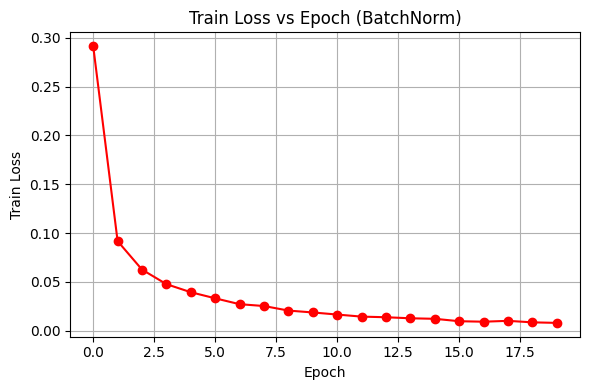

In [23]:
df = pd.read_csv("/Users/merterol/Desktop/iMac27_github/uzh/Computational Science/Sem 4/PHY371/MNIST_exp/MNIST_Experiment_BN/version_4/metrics.csv")

df = df.dropna(subset=["train_loss_epoch"])

loss_per_epoch = df.groupby("epoch")["train_loss_epoch"].mean()

plt.figure(figsize=(6, 4))
plt.plot(loss_per_epoch.index, loss_per_epoch.values, marker='o', color='red')
plt.title("Train Loss vs Epoch (BatchNorm)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5) Conclusion (3 Point)
Comment on your findings:
- Which method is better? Why?

ANSWER:

BatchNorm alone is clearly the most effective here, providing the lowest final loss and most stable training.

- Are the results statistically significant? If not, how can we get significant ones?

ANSWER:

The stability and lower loss indicate a statistically significant difference, as the variance in the dropout models is much higher.

* Comment on different normalization techniques: `BatchNorm`, `LayerNorm` , `InstanceNorm` and `GroupNorm`. Explain the purpose of usage of them in general (for the RGB datasets, etc).

ANSWER:
- Batch Norm
  - Normalizes activations across a mini batch (lovers internal covariate shift)
  - Computes mean and variance for each feature across the batch, then scalees and shift the normalized output
  - Common in CNNs (captures spatial dependencies well and speeds up convergence)
  - Worse performance with small batch sizes
- Layer Norm
  - Normalize across the features within each training sample (effective for RNNs and NLP tasks)
  - Computes statistics independently for eah sample (considers all features in a layer)
  - Used often in transformers and attention-based models where input length varies alot
  - Less effective in CNNs
- Instance Norm
  - Used in syle transfer and image generation tasks (norms eachg feature map independently for each sample)
  - Like LayerNorm but without considering the entire batch
  - Ideal for GANs
  - Can reduce model expressive ess if used inappropiately
- Group Norm
  - Balances BathNorm and LayerNorm (groups channels to norm)
  - Divides channels into groups and normalizes each group seperately
  - Effictive in 3D vision tasks, object detection (smaller batch sizes)
  - Requires careful tuning fo the number of groups for optimal performance

* Explain the operations of the `Dropout` layer in training and testing phase. Is there any difference, or are they always the same?

ANSWER:
- Training:
  - Dropout randomly sets a fraction p of the neurons to 0 at each forward pass
  - Tis is done to prevent overfitting by reducing co-adaptation between neursons
  - Remaining neurons are scaled up to maintain the expected output magnitude
- Testing
  - Dropout is disabled
  - Scaling i snot applied

* Explain the difference between `AdamW` and `Adam` optimizers in a few sentences.

Hint: https://arxiv.org/abs/1711.05101 for more information.

ANSWER:
- Adam:
  - Applies weight decay as part of the gradient update
  - Weight decay acts like an l2 penalty (affects both direction and magnitude of gradient)
  - Can lead to suboptimal convergence and maybe overfitting
- AdamW
  - Seperates weight decay from gradient update (apply directly to weights after optim step)
  - True weight decay (affects only the magnitude)
  - Results in better generalization and more robust training

* Compare the Kaiming (He) and Xavier (Glorot) Initialization techniques and explain their differences in a few sentences. 

Hint: You can find more information from their original papers.

ANSWER:
- Kaiming:
  - Designed for deep nets with ReLU or similar functions
  - Helps mitigate the vanishing gradient problem by keeping variance high
- Xavier:
  - Designed for networks with symmetric, linear, or tanh activation
  - Balanced starting point for forward and backward signal flow (but might struggle with very deep nets using ReLU)